In [1]:
import shapely
import pandas as pd
from shapely.geometry import LineString
from shapely.geometry import Point
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy
from datetime import timedelta
import pyproj

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
import route2vel
from notebookutils import *

from route2vel.interp import *
from route2vel.route import *
from route2vel.classes import *

In [2]:
from route2vel.postprocess import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use('dark_background')
route2vel.load_config("..")
ox.settings.use_cache = False

In [5]:
route_steps = ["Zola Predosa", "Castel San Pietro Terme"]

In [24]:
direction = route2vel.find_route_osrm(route_steps, load_graph=True, load_graph_name='test_route_1')

Loading graph from d:\Documenti\Universita\tesim\route2vel\src\resources\graph\test_route_1.graphnx.pickle ...
Loaded in 0.18s!


In [8]:
print(f"Route length: {len(direction.geometry)} (osm nodes: {len(direction.nodelist())})")

Route length: 28 (osm nodes: 64)


In [9]:
interp_dir = route2vel.interp_from_route(direction)

d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


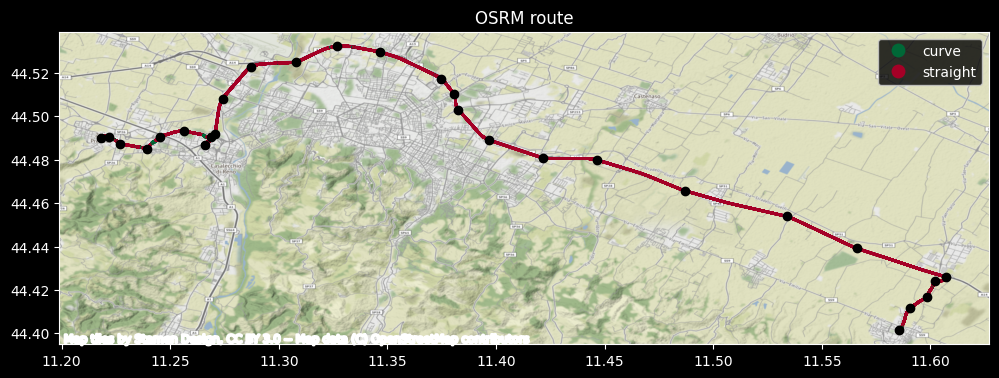

In [10]:
interp_dir.plot()

In [11]:
gdf = interp_dir.split_gdf
gdf0 = gdf.to_crs(CRS(proj='utm', zone=32, units="m", ellipsis="WGS84"))
gdf1 = gpd.GeoDataFrame({
    "geometry": gdf0.geometry,
    "iscurve": gdf0.iscurve.astype(bool),
    "num": [len(line.coords) for line in gdf0.geometry],
    "length": [line.length for line in gdf0.geometry],
})
print("Not curve")
display(gdf1[~gdf1.iscurve].describe())
print("Curve")
display(gdf1[gdf1.iscurve].describe())

Not curve


,num,length
count,73.000000,73.000000
mean,8.424658,562.479287
std,16.881053,1946.818569
min,2.000000,15.205314
25%,2.000000,40.598774
50%,3.000000,79.385770
75%,6.000000,277.473994
max,88.000000,15206.729967


Curve


,num,length
count,59.000000,59.000000
mean,4.593220,32.618356
std,5.493315,49.628344
min,2.000000,2.183433
25%,2.000000,11.500422
50%,3.000000,14.657794
75%,5.000000,34.700605
max,38.000000,329.437955


In [12]:
meters_density = 5
pt_num = interp_dir.pt_num_for_density(meters_density)
print(f"For meters density {meters_density}m using {pt_num} points")

For meters density 5m using 8607 points


Testing with a roundabout tract (see [workflow_2.ipynb](./workflow_2.ipynb)).

In [13]:
route_bounds = ((11.237, 44.484), (11.242, 44.488))

In [14]:
# For testing, just crop the whole route instead of finding another shorter one
route2vel.utils.debug = True
gdf = interp_dir.get_points_with_num(pt_num, return_gdf=True, in_meters=True, gdf_columns=['base_idx', 'junction', 'speed_kph'])
proj_crs = gdf.crs
proj_crs

Projecting to UTM zone 32 (auto, from point [11.34890858 44.47679858])


<Projected CRS: +proj=utm +zone=32 +units=m +ellipsis +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
calc_curvature(gdf)

In [16]:
gdf.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
0,POINT Z (676483.439 4928792.660 80.000),False,0,0,NaN,90.0,7.866151e-08
1,POINT Z (676487.937 4928791.611 80.269),False,0,0,NaN,90.0,1.180232e-07
2,POINT Z (676492.434 4928790.562 80.537),False,0,0,NaN,90.0,7.358897e-05
3,POINT Z (676496.932 4928789.514 80.806),False,0,0,NaN,90.0,4.220687e-04
4,POINT Z (676501.430 4928788.471 80.930),True,1,1,NaN,90.0,4.210207e-04


In [17]:
crop = clip_interp_gdf(gdf, route_bounds, Transformer.from_crs(direction.gdf.crs, proj_crs, always_xy=True).transform)
crop.describe()

,split_gdf_index,base_idx,speed_kph,curvature
count,120.000000,120.000000,120.000000,1.200000e+02
mean,39.733333,22.983333,52.333333,1.370174e-02
std,3.031303,2.650458,9.414215,3.035934e-02
min,33.000000,17.000000,50.000000,1.442893e-07
25%,36.750000,20.000000,50.000000,1.483272e-07
50%,42.000000,25.000000,50.000000,4.070341e-04
75%,42.000000,25.000000,50.000000,1.215783e-02
max,43.000000,26.000000,90.000000,2.437657e-01


In [18]:
crop.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
328,POINT Z (677884.897 4928236.136 73.638),True,33,17,NaN,50.0,0.000941
329,POINT Z (677889.363 4928234.824 73.984),True,33,17,NaN,50.0,0.000955
330,POINT Z (677893.835 4928233.556 74.329),True,33,17,NaN,50.0,0.001437
331,POINT Z (677898.304 4928232.259 74.674),True,33,17,NaN,50.0,0.003536
332,POINT Z (677902.756 4928230.852 74.979),True,34,18,NaN,50.0,0.003632


In [19]:
print(f"Cropped points: {len(crop)}, {100 * len(crop) / len(gdf):.2f}%")

Cropped points: 120, 1.39%


d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


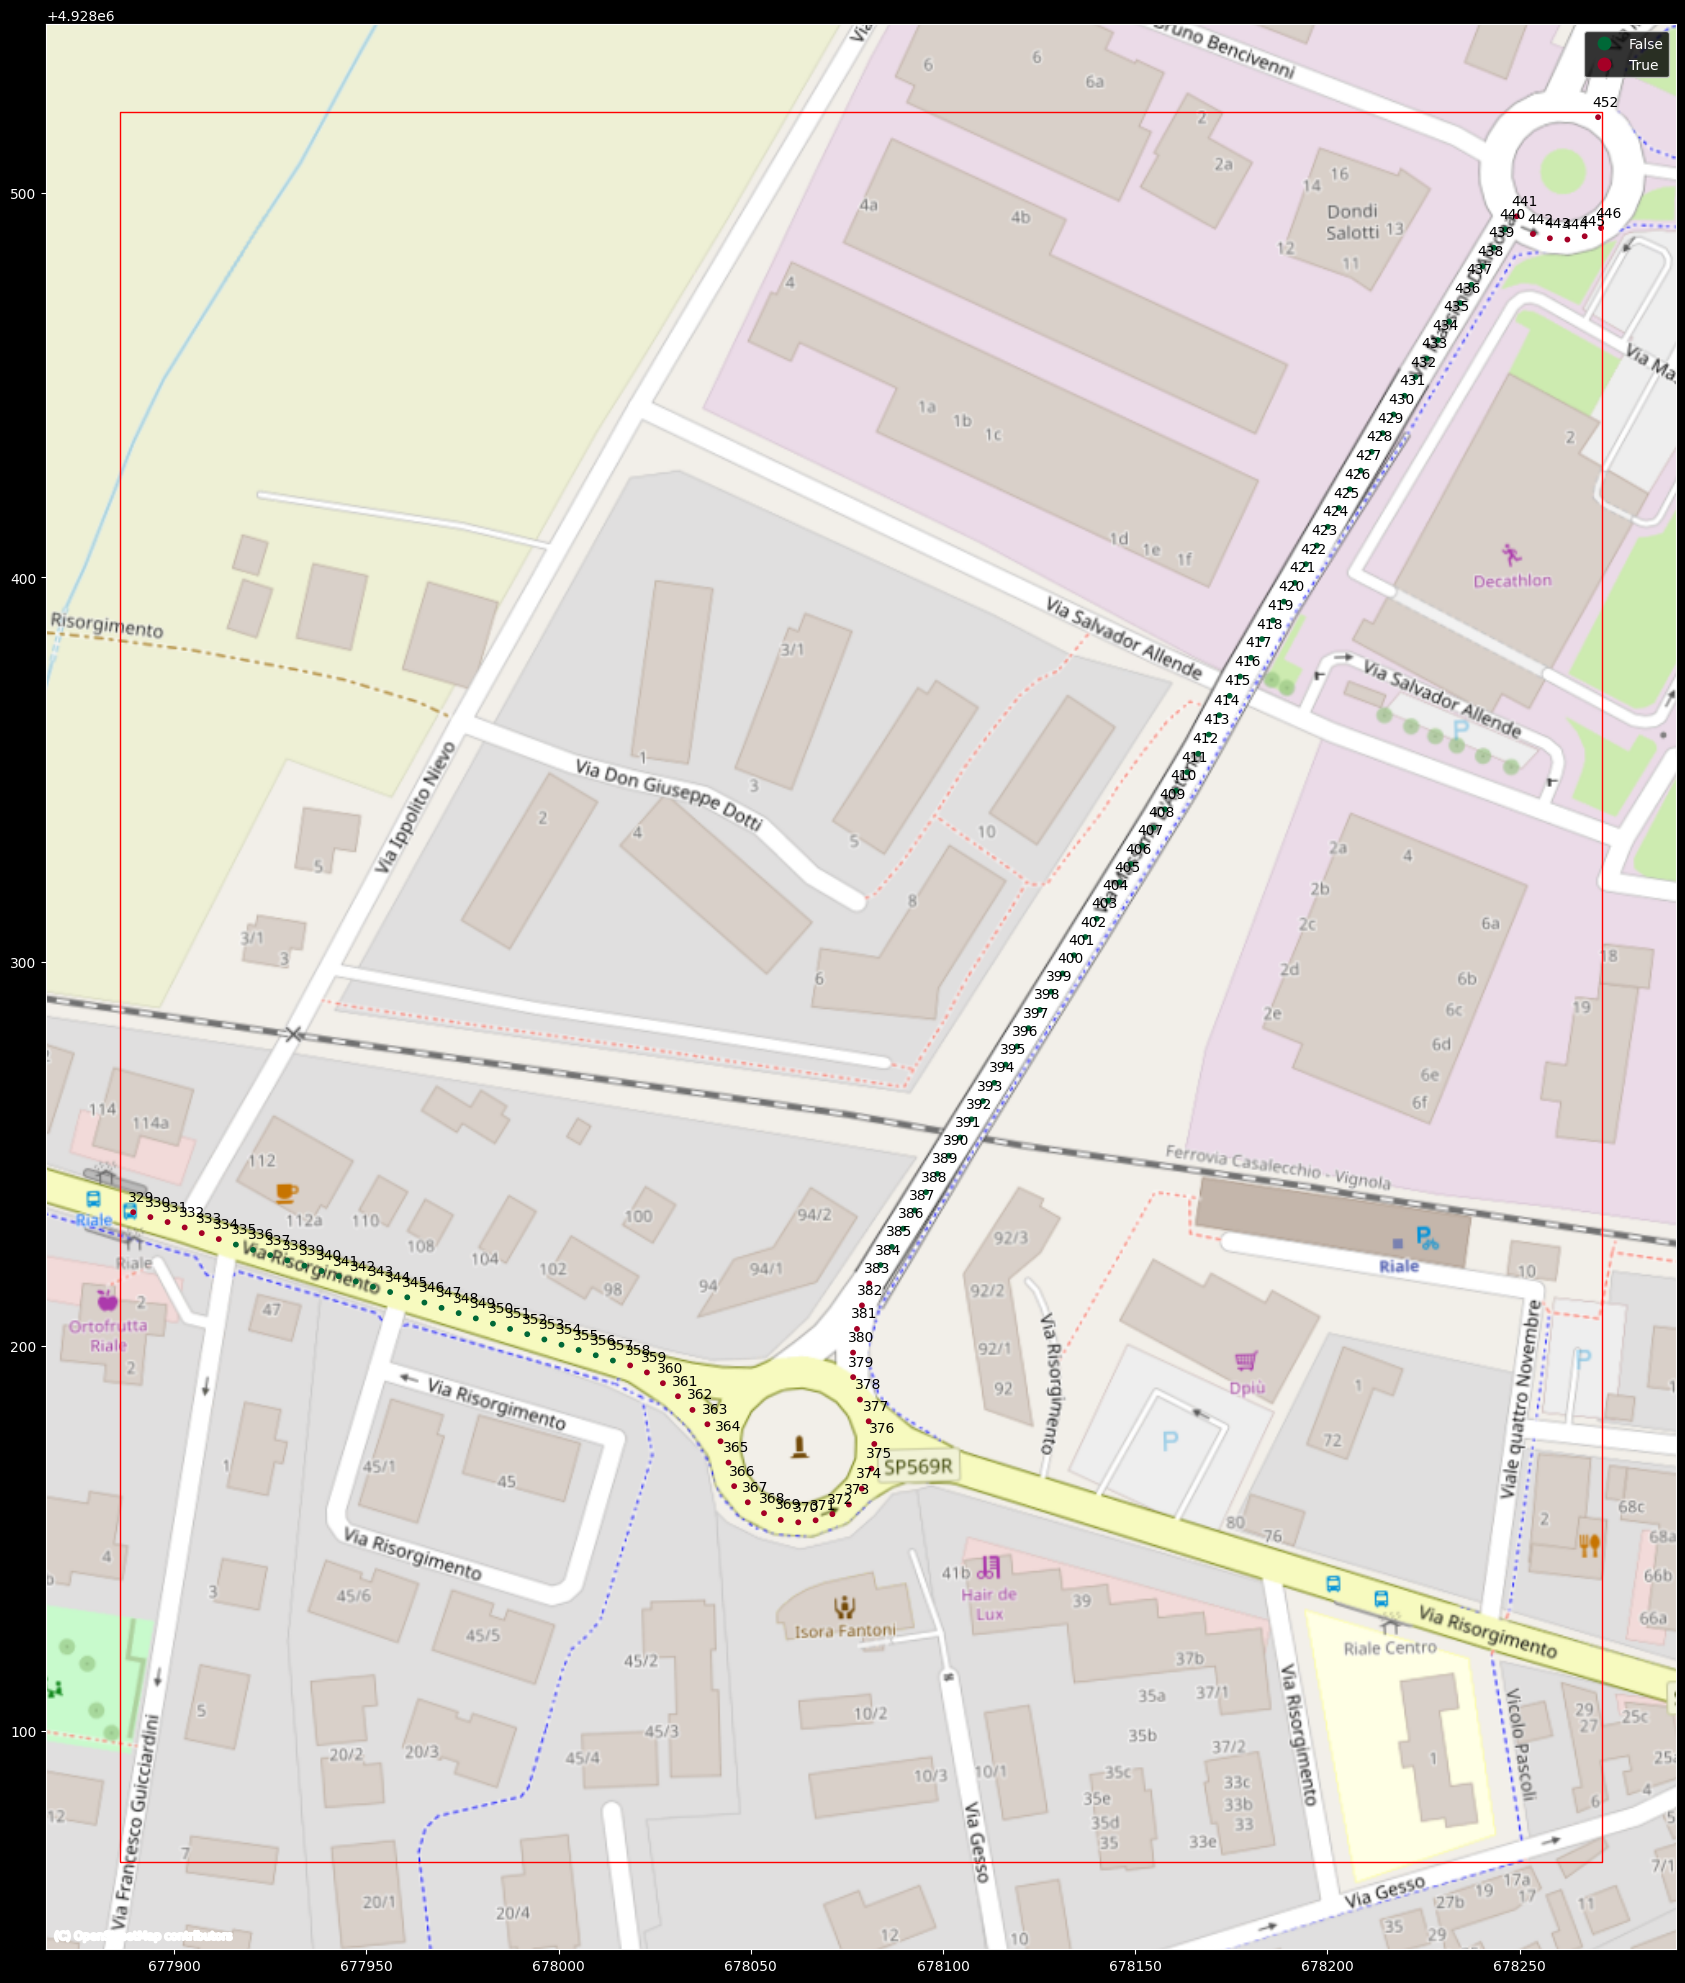

In [20]:
tr = pyproj.Transformer.from_crs(direction.gdf.crs, gdf.crs, always_xy=True).transform
display_bounded_shapes([
    (gdf.reset_index(), {'column': 'is_curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 10}, {
        "column": "index",
        "offset": (2, 4),
        "fontsize": 15
    }),
], tr(*route_bounds[0]), tr(*route_bounds[1]), crs=gdf.crs, figsize=(25,25));

In [21]:
crop_offset = offset_meters_gdf(crop)
crop_offset.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
328,POINT Z (0.000 81.979 73.638),True,33,17,NaN,50.0,0.000941
329,POINT Z (4.466 80.668 73.984),True,33,17,NaN,50.0,0.000955
330,POINT Z (8.939 79.399 74.329),True,33,17,NaN,50.0,0.001437
331,POINT Z (13.407 78.102 74.674),True,33,17,NaN,50.0,0.003536
332,POINT Z (17.859 76.695 74.979),True,34,18,NaN,50.0,0.003632


In [22]:
fname = "../route_output.csv"
interp_gdf_to_csv(crop_offset, fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../../route_output.csv


In [23]:
fname = "../route_output_full.csv"
interp_gdf_to_csv(offset_meters_gdf(gdf), fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../../route_output_full.csv
